In [1]:
from __future__ import print_function
from __future__ import division
import rospy, rosbag, tf
from geometry_msgs.msg import Point, Quaternion
from sensor_msgs.msg import Image, CameraInfo
from sensor_msgs.msg import NavSatFix
from sensor_msgs.msg import PointCloud2, PointField
from nav_msgs.msg import Odometry
import cv2, cv_bridge
from image_geometry import PinholeCameraModel
import numpy as np
import csv, sys, os, copy
from collections import defaultdict
import PyKDL as kd
from camera_info import *
from utils import *
from parse_tracklet import *
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import cluster

In [2]:
DUMMY_FIELD_PREFIX = '__'

# mappings between PointField types and numpy types
type_mappings = [(PointField.INT8, np.dtype('int8')), (PointField.UINT8, np.dtype('uint8')), (PointField.INT16, np.dtype('int16')),
                 (PointField.UINT16, np.dtype('uint16')), (PointField.INT32, np.dtype('int32')), (PointField.UINT32, np.dtype('uint32')),
                 (PointField.FLOAT32, np.dtype('float32')), (PointField.FLOAT64, np.dtype('float64'))]

pftype_to_nptype = dict(type_mappings)
nptype_to_pftype = dict((nptype, pftype) for pftype, nptype in type_mappings)

# sizes (in bytes) of PointField types
pftype_sizes = {PointField.INT8: 1, PointField.UINT8: 1, PointField.INT16: 2, PointField.UINT16: 2,
                PointField.INT32: 4, PointField.UINT32: 4, PointField.FLOAT32: 4, PointField.FLOAT64: 8}



def fields_to_dtype(fields, point_step):
    '''Convert a list of PointFields to a numpy record datatype.
    '''
    offset = 0
    np_dtype_list = []
    for f in fields:
        while offset < f.offset:
            # might be extra padding between fields
            np_dtype_list.append(('%s%d' % (DUMMY_FIELD_PREFIX, offset), np.uint8))
            offset += 1

        dtype = pftype_to_nptype[f.datatype]
        if f.count != 1:
            dtype = np.dtype((dtype, f.count))

        np_dtype_list.append((f.name, dtype))
        offset += pftype_sizes[f.datatype] * f.count

    # might be extra padding between points
    while offset < point_step:
        np_dtype_list.append(('%s%d' % (DUMMY_FIELD_PREFIX, offset), np.uint8))
        offset += 1

    return np_dtype_list

def msg_to_arr(msg):

    dtype_list = fields_to_dtype(msg.fields, msg.point_step)
    arr = np.fromstring(msg.data, dtype_list)

    # remove the dummy fields that were added
    arr = arr[[fname for fname, _type in dtype_list if not (fname[:len(DUMMY_FIELD_PREFIX)] == DUMMY_FIELD_PREFIX)]]

    if msg.height == 1:
        return np.reshape(arr, (msg.width,))
    else:
        return np.reshape(arr, (msg.height, msg.width))

In [3]:
CAMERA_TOPICS = ["/image_raw"]

class Frame():
    def __init__(self, trans, rotq, object_type, size):
        self.trans = trans
        self.rotq = rotq
        self.object_type = object_type
        self.size = size

def extract_bag_timestamps(bag_file, topics=CAMERA_TOPICS):
    timestamp_map = {}
    index = 0
    with rosbag.Bag(bag_file, "r") as bag:
        for topic, msg, ts in bag.read_messages(topics):
            timestamp_map[msg.header.stamp.to_nsec()] = index
            index += 1
    return timestamp_map


def generate_frame_map(tracklets):
    # map all tracklets to one timeline
    frame_map = defaultdict(list)
    for t in tracklets:
        for i in range(t.num_frames):
            frame_index = i + t.first_frame
            rot = t.rots[i]
            rotq = kd.Rotation.RPY(rot[0], rot[1], rot[2]).GetQuaternion()
            frame_map[frame_index].append(
                Frame(
                    t.trans[i],
                    rotq,
                    t.object_type,
                    t.size))
    return frame_map

In [235]:
#bag_file = '/home/prerit/DiDi/Data/bags/suburu_pulling_to_left/suburu04.bag'
#tracklet_file = '/home/prerit/DiDi/Data/tracklets/suburu_pulling_to_left/suburu04.xml'
#out_file = '/home/prerit/DiDi/Data/tracklets/suburu_pulling_to_left/ground_correction.csv'
#bag_file = '/home/prerit/DiDi/Data/bags/bmw_sitting_still/bmw01.bag'
#tracklet_file = '/home/prerit/DiDi/Data/tracklets/bmw_sitting_still/bmw01.xml'
# bag_file = '/home/prerit/DiDi/Data/bags/nissan_pulling_to_right/nissan04.bag'
# tracklet_file = '/home/prerit/DiDi/Data/tracklets/nissan_pulling_to_right/nissan04.xml'
# out_file = '/home/prerit/DiDi/Data/tracklets/nissan_pulling_to_right/ground_correction.csv'
# bag_file = '/home/prerit/DiDi/Data/bags/nissan_sitting_still/nissan01.bag'
# tracklet_file = '/home/prerit/DiDi/Data/tracklets/nissan_sitting_still/nissan01.xml'
# out_file = '/home/prerit/DiDi/Data/tracklets/nissan_sitting_still/ground_correction.csv'
bag_file = '/media/prerit/Data/didi_data/suburu/suburu_driving_parallel/suburu10.bag'
tracklet_file = '/media/prerit/Data/didi_data/suburu/suburu_driving_parallel/suburu10.xml'
out_file = '/media/prerit/Data/didi_data/suburu/suburu_driving_parallel/ground_correction.csv'
# bag_file = '/home/prerit/DiDi/Data/bags/nissan_driving_past_it/nissan07.bag'
# tracklet_file = '/home/prerit/DiDi/Data/tracklets/nissan_driving_past_it/nissan07.xml'
# out_file = '/home/prerit/DiDi/Data/tracklets/nissan_driving_past_it/ground_correction.csv'
bag = rosbag.Bag(bag_file)
info = bag.get_type_and_topic_info()
info.topics.keys()

['/radar/tracks',
 '/objects/obs1/front/gps/time',
 '/objects/capture_vehicle/front/gps/fix',
 '/objects/obs1/rear/gps/rtkfix',
 '/objects/obs1/front/gps/rtkfix',
 '/velodyne_nodelet_manager/bond',
 '/objects/capture_vehicle/front/gps/time',
 '/velodyne_packets',
 '/objects/obs1/rear/gps/fix',
 '/diagnostics',
 '/objects/capture_vehicle/rear/gps/rtkfix',
 '/radar/range',
 '/objects/capture_vehicle/rear/gps/fix',
 '/image_raw',
 '/velodyne_points',
 '/diagnostics_toplevel_state',
 '/objects/capture_vehicle/rear/gps/time',
 '/objects/obs1/rear/gps/time',
 '/radar/points',
 '/diagnostics_agg',
 '/objects/obs1/front/gps/fix',
 '/objects/capture_vehicle/front/gps/rtkfix']

In [245]:
bag_file = '/media/prerit/Data/didi_data/cmax/cmax_following_long/cmax02.bag'
bag = rosbag.Bag(bag_file)
count=0
for msg in bag.read_messages():
    print(msg.timestamp.to_sec())
    count+=1
    if count>20:
        break
bag.get_end_time()

1492895988.2
1492895988.2
1492895988.21
1492895988.21
1492895988.21
1492895988.21
1492895988.21
1492895988.23
1492895988.23
1492895988.24
1492895988.24
1492895988.24
1492895988.24
1492895988.24
1492895988.25
1492895988.25
1492895988.25
1492895988.25
1492895988.27
1492895988.27
1492895988.29


1492896585.384664

In [246]:
6585-5988

597

In [5]:
timestamp_map = extract_bag_timestamps(bag_file)
tracklets = parse_xml(tracklet_file)
frame_map = generate_frame_map(tracklets)
velodyne_timestamps = extract_bag_timestamps(bag_file, topics=['/velodyne_points'])

camera_df = pd.DataFrame({'cam_index':timestamp_map})
camera_df.index = pd.to_datetime(camera_df.index)
velodyne_df = pd.DataFrame({'vel_index':velodyne_timestamps})
velodyne_df.index = pd.to_datetime(velodyne_df.index)
time_df = pd.merge(camera_df, velodyne_df, left_index=True, right_index=True, how='outer')
time_df = time_df.interpolate(method='time', limit=100, limit_direction='both')
time_df = time_df.round().astype(int)
time_df.index = time_df.index.astype(np.int64)
time_df.head()

Parsing Tracklet file /media/prerit/Data/didi_data/suburu/suburu_driving_parallel/suburu10.xml
File contains 1 Tracklets
Loaded 1 Tracklets


,cam_index,vel_index
1492889101796125792,0,0
1492889101837405000,1,0
1492889101837831229,1,0
1492889101879518993,2,0
1492889101921202023,3,1


currently on  1492889150079223000
[ 12.931777   4.417028  -0.624052] [ 2.71799856  2.11707135  1.1255    ]
124 148
hard corner 28
soft corner 131 0
slopes -1.70145 0.581657
hard corner 131
soft corner 28 0
slopes -1.70145 1.36331
[ 12.809807   4.801392  -0.61402 ] [ 2.71415336  2.14157996  1.1255    ]
125 148
hard corner 24
soft corner 135 0
slopes -1.76102 0.569849
hard corner 135
soft corner 24 0
slopes -1.76102 1.38968
[ 12.590518   5.393741  -0.60633 ] [ 2.70530425  2.18685752  1.1255    ]
127 148
hard corner 17
soft corner 131 0
slopes -1.7631 0.588373
hard corner 131
soft corner 17 0
slopes -1.7631 1.44052
[ 12.437311   5.787532  -0.607388] [ 2.69908068  2.21301459  1.1255    ]
128 147
hard corner 14
soft corner 124 1
slopes -1.57778 0.936211
hard corner 123
soft corner 124 1
slopes 1.35273 -5.90867
hard corner 124
soft corner 14 123
slopes -1.57778 1.35273
hard corner 1
soft corner 14 123
slopes 0.936211 -5.90867
[ 12.265396   6.172566  -0.608959] [ 2.69041293  2.2445051   1.125

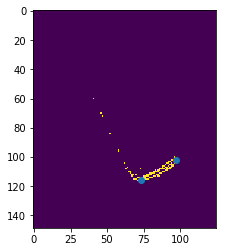

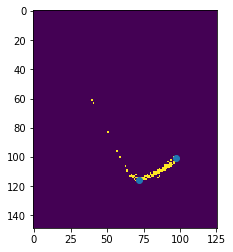

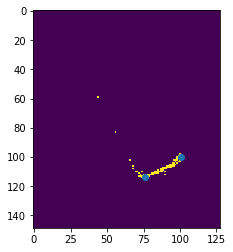

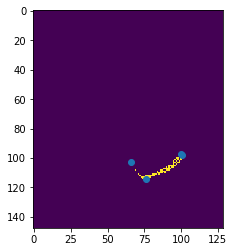

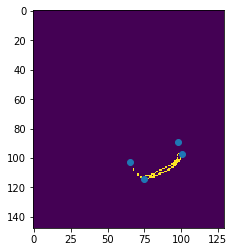

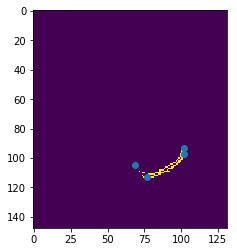

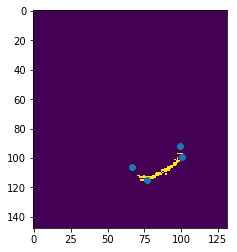

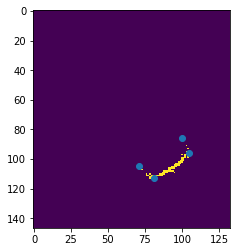

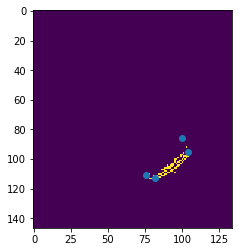

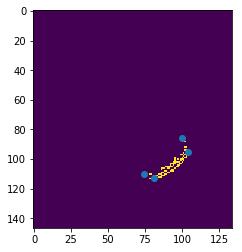

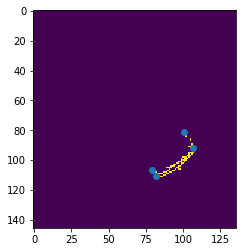

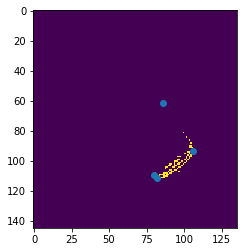

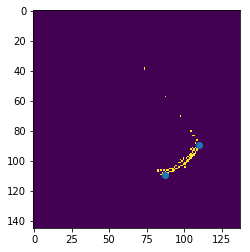

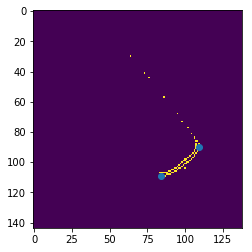

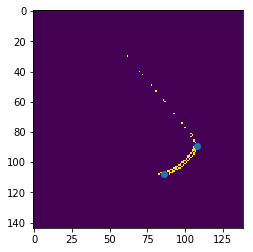

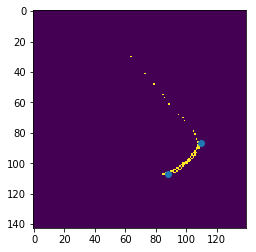

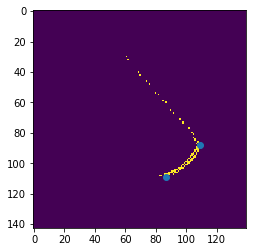

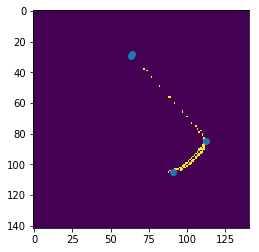

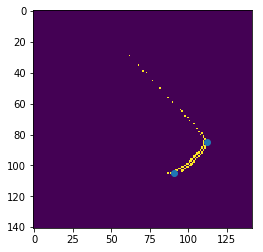

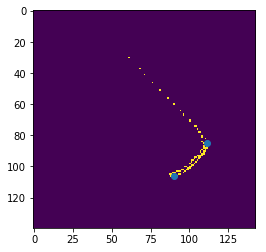

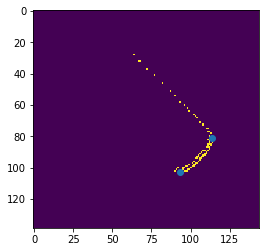

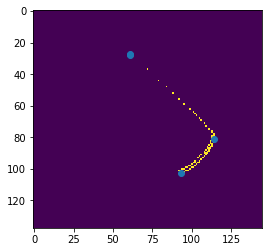

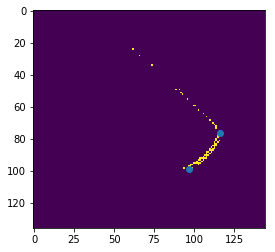

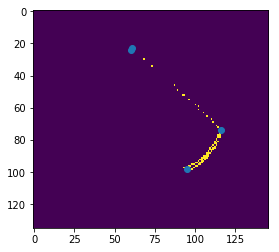

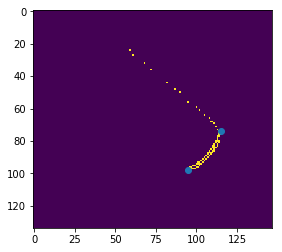

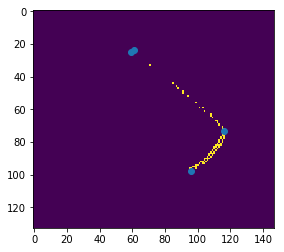

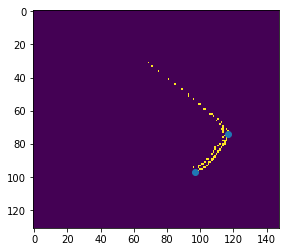

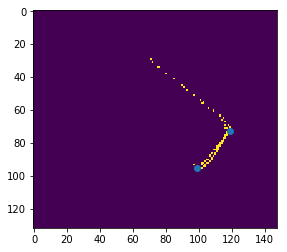

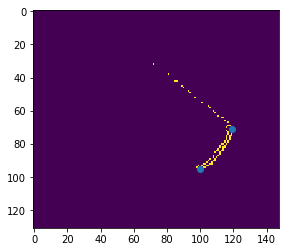

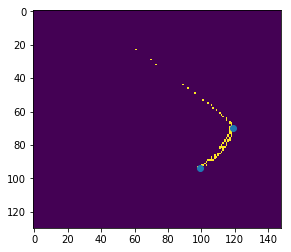

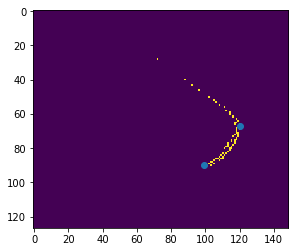

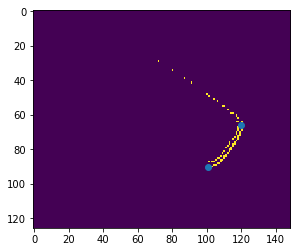

In [230]:
count = 0
template=None

def get_patch(points, corners):
    x_points = points[:, 0]
    y_points = points[:, 1]
    z_points = points[:, 2]
    reflectance = points[:,3]
    
    range_min = np.min(corners, axis=0)
    range_max = np.max(corners, axis=0)
    center = (range_max+range_min)/2
    size = np.abs(range_max - range_min)/2+0.3
    print(center, size)
    z_min = -2.5
    
    search_size = 5
    z_max = min(-1.2, max(-1.2, center[2]/2))
    
    # filter capture vehicle
    c_filt = np.logical_or(np.abs(x_points)>4.7/2, np.abs(y_points)>2.1/2)
    
    f_z = (z_points < z_max) & (z_points > z_min) 
    
    k_means = cluster.KMeans(n_clusters=3)
    
    # filter obstacle vehicle 
    indices = []
    
    while(len(indices)<50) :
        f_x = (np.abs(x_points-center[0]) > size[0]) & (np.abs(x_points-center[0]) < search_size)
        f_y = (np.abs(y_points-center[1]) > size[1]) & (np.abs(y_points-center[1]) < search_size)
        indices = np.argwhere(f_x & f_y & f_z & c_filt).flatten()
        search_size += 5
        
   
    xi_points = (x_points[indices]-center[0]+search_size).astype(np.int32)
    yi_points = (y_points[indices]-center[1]+search_size).astype(np.int32)
    zi_points = z_points[indices]
    k_means.fit(zi_points.reshape((-1,1)))
    labels, counts = np.unique(k_means.labels_ , return_counts=True)
    ground_cluster = labels[np.argmax(counts)]
    ground_height = k_means.cluster_centers_[ground_cluster][0]
    #return ground_height
            
    
    f_x = (np.abs(x_points-center[0]) < size[0]+1) 
    f_y = (np.abs(y_points-center[1]) < size[1]+1)
    f_z = (z_points > ground_height+0.4) & (z_points < ground_height+1)
    indices = np.argwhere(f_x & f_y & f_z & c_filt).flatten()
    xi_points = x_points[indices]
    yi_points = y_points[indices]
    zi_points = z_points[indices]
    res=0.05
    x_max = int(2*(size[1]+1)/res)
    y_max = int(2*(size[0]+1)/res)
    print(x_max,y_max)
    top = np.zeros((y_max+1, x_max+1), dtype=np.uint8)
    x_img = (abs(yi_points - center[1] - size[1]-1)/ res).astype(np.int32)  # x axis is -y in LIDAR
    y_img = (abs(xi_points - center[0] - size[0]-1)/ res).astype(np.int32)  # y axis is -x in LIDAR
    top[y_img, x_img] = 255
    kernel = np.ones((5,5),np.uint8)
    #top = cv2.dilate(top,kernel,iterations = 1)
    
    ix_min, ix_max = np.argmin(xi_points), np.argmax(xi_points)
    iy_min, iy_max = np.argmin(yi_points), np.argmax(yi_points)
    x_min, x_max = xi_points[ix_min], xi_points[ix_max]
    y_min, y_max = yi_points[iy_min], yi_points[iy_max]
    plt.figure()
    plt.imshow(top)
    corners = {'x':[], 'y':[]}
    for i in [ix_min, ix_max] :
        if y_min<yi_points[i]<y_max :
            print("hard corner", i)
            x = (abs(yi_points[i] - center[1] - size[1]-1)/ res).astype(np.int32)
            y = (abs(xi_points[i] - center[0] - size[0]-1)/ res).astype(np.int32)
            corners['x'].append(x)
            corners['y'].append(y)
            print("soft corner", iy_min, iy_max)
            print("slopes", (y_min-yi_points[i])/(xi_points[iy_min]-xi_points[i]), 
                            (y_max-yi_points[i])/(xi_points[iy_max]-xi_points[i]))
    for i in [iy_min, iy_max] :
        if x_min<xi_points[i]<x_max :
            print("hard corner", i)
            print("soft corner", ix_min, ix_max)
            x = (abs(yi_points[i] - center[1] - size[1]-1)/ res).astype(np.int32)
            y = (abs(xi_points[i] - center[0] - size[0]-1)/ res).astype(np.int32)
            corners['x'].append(x)
            corners['y'].append(y)
            print("slopes", (yi_points[ix_min]-yi_points[i])/(x_min-xi_points[i]), 
                            (yi_points[ix_max]-yi_points[i])/(x_max-xi_points[i]))
    plt.scatter(corners['x'], corners['y'])
    return top
    #minLineLength = 15
    #maxLineGap = 5
    #lines = cv2.HoughLinesP(top,1,np.pi/180,30,minLineLength,maxLineGap)
    #top = cv2.cvtColor(top,cv2.COLOR_GRAY2RGB)
    #print(lines)
    #for x1,y1,x2,y2 in lines[0]:
    #    cv2.line(top,(x1,y1),(x2,y2),(0,255,0),10)
    #top = lsd.drawSegments(top,lines)
#     kp1, des1 = orb.detectAndCompute(edges,None)
#     kp2, des2 = orb.detectAndCompute(template,None)
#     # create BFMatcher object
#     bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

#     # Match descriptors.
#     matches = bf.match(des1,des2)
    
#     # Sort them in the order of their distance.
#     matches = sorted(matches, key = lambda x:x.distance)

#     # Draw first 10 matches.
#     img3 = cv2.drawMatches(edges,kp1,template,kp2,matches[:10], flags=2)

#     plt.figure()
#     plt.imshow(img3)
    #plt.imshow(edges)
    
    #print(xi_points)
    
#     k_means = cluster.KMeans(n_clusters=6- int(center[0]//10))
#     k_means.fit(xi_points.reshape((-1,1)))
#     labels, counts = np.unique(k_means.labels_ , return_counts=True)
#     print(sum(counts), counts, k_means.cluster_centers_, [range_min[0], range_max[0]])
    #x_select = []
    #y_select = []
    #for i in np.argsort(counts)[-3:] :
    #    x_select.append(x_points[indices[k_means.labels_== labels[np.argmax(counts)] ]])
    #    y_select.append(y_points[indices[k_means.labels_== labels[np.argmax(counts)] ]])
    #print(y_select,  np.min(y_select), np.max(y_select), range_min[1], range_max[1])
    #return [ground_height, np.min(x_select), np.max(x_select), np.min(y_select), np.max(y_select)]
    #for label 
    #print(k_means.labels_.r)
    
    
            #return k_means.cluster_centers_[ground_cluster][0]
#             size = 2*search_size+1
#             # INITIALIZE EMPTY ARRAY - of the dimensions we want
#             top = np.zeros([size, size], dtype=np.float32)
#             top[xi_points, yi_points] = zi_points - z_min
#             print(search_size, len(zi_points), np.median(zi_points), np.min(zi_points), np.mean(zi_points), range_min[2])
#             return top
#             #return (search_size, len(zi_points), np.median(zi_points), np.min(zi_points), np.mean(zi_points), range_min[2])

df = pd.DataFrame(index=sorted(velodyne_timestamps.keys()), columns=['z_min','x_min','x_max','y_min', 'y_max'])
with rosbag.Bag(bag_file, 'r') as bag:
    #for topic, msg, t in bag.read_messages(topics='/velodyne_points'):
    for topic, msg, t in bag.read_messages(topics='/velodyne_points', start_time=rospy.Time.from_sec(1492889150.0)):
        timestamp = t.to_nsec()
        if (timestamp//1e8)%10 == 0 :
            print('currently on ', timestamp)
        arr = msg_to_arr(msg)
        lidar = np.array([[a[0], a[1], a[2], a[3]] for a in arr])
        frame_index = time_df.loc[[t.to_nsec()]].cam_index.values[0]
        for i, f in enumerate(frame_map[frame_index]):
            dims = f.size[::-1]
            obs_centroid = np.array(f.trans)
            R = tf.transformations.quaternion_matrix(f.rotq)
            corners = [0.5*np.array([i,j,k])*dims for i in [-1,1] 
                        for j in [-1,1] for k in [-1,1]]
            corners = [obs_centroid + R.dot(list(c)+[1])[:3] for c in corners]
            #print(corners, np.max(corners, axis=0), np.min(corners, axis=0))
            template = get_patch(lidar, corners)
            #df.loc[timestamp] = [get_patch(lidar, corners),0,0,0,0]
            #h = get_patch(lidar, corners)
            #print(t.to_nsec(), h)
            #ground_height.append(h)
            #print(patch)
            #fi = plt.figure()
            #plt.imshow(patch, cmap="hot")
        if (count>30):
            break
        count+=1

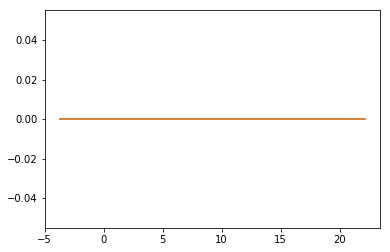

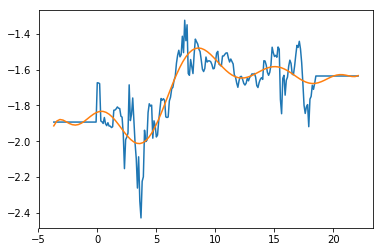

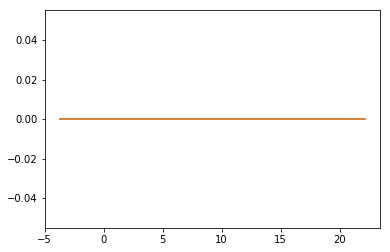

In [9]:
t = sorted(np.array(velodyne_timestamps.keys()))
t0 = min(t)
t = (t-t0)/1e9
extra = 0.2*t[-1]
n = int(10*extra)

df = df.sort_index()
df.index = t
df_pre = pd.concat([pd.DataFrame(df.iloc[:n].mean()).transpose()]*n)
df_pre.index = np.linspace(-extra, -0.1, n)
df_post = pd.concat([pd.DataFrame(df.iloc[-n:].mean()).transpose()]*n)
df_post.index = np.linspace(t[-1]+0.1, t[-1]+extra, n)
df_new = pd.concat([df_pre, df, df_post])
#valid = df_new.x_max<20

poly = {'z_min':None, 'x_min':None, 'y_min':None}
#valid_range = {'z_min':(-2.5,-1.0), 'x_min':(50,-18), 'x_max':(18,-50) , 'y_min':50}
valid_range = {'z_min':2.5, 'x_min':50, 'x_max':50 , 'y_min':50, 'y_max':50}
#valid_indices = {'z_min':None, 'x_min':None, 'y_min':None} 
valid_indices = None


mask = (np.abs(df_new.x_min)<valid_range['x_min']) \
    & (np.abs(df_new.y_min)<valid_range['y_min'])  \
    & (np.abs(df_new.z_min)<valid_range['z_min'])

subset = df_new[mask]    
    
z0 = np.polyfit(subset.index, subset['z_min'], 13)
poly['z_min'] = np.poly1d(z0)    
    
#subset = df_new[mask]
z1 = np.polyfit(subset.index, subset['x_min'], 13)
poly['x_min'] = np.poly1d(z1)

#subset = df_new[mask]
z2 = np.polyfit(subset.index, subset['y_min'], 13)
poly['y_min'] = np.poly1d(z2)

for key in poly.keys() :
    fig = plt.figure()
    #valid_indices[key] = [i for i in range(len(df)) if np.abs(df.iloc[i][key])<valid_range[key]]
    #subset = df.iloc[valid_indices[key]]
    tp = np.linspace(subset.index[0], max(t)+extra, 100)
    plt.plot(df_new.index, df_new[key])
    plt.plot(tp, poly[key](tp))

In [911]:
df_out = pd.DataFrame(index=sorted(timestamp_map.keys()), columns=['z_min','x_min','y_min'])
t = df_out.index
t = (t-t0)/1e9
valid_indices = np.argwhere(mask).flatten()
mask1 = np.in1d(time_df['vel_index'], valid_indices)
mask2 = np.in1d(time_df[mask1].index, df_out.index)
valid_times = time_df[mask1][mask2].index
for key in poly.keys():
     df_out.loc[valid_times, key] = poly[key]((valid_times-t0)/1e9)
df_out.to_csv(out_file, index_label=False)

In [912]:
pd.read_csv(out_file)

,z_min,x_min,y_min
1492892605465855961,-1.838113,0.0,0.0
1492892605507552100,-1.837051,0.0,0.0
1492892605549187854,-1.836106,0.0,0.0
1492892605590914163,-1.835279,0.0,0.0
1492892605632594083,-1.834574,0.0,0.0
1492892605674184158,-1.833997,0.0,0.0
1492892605715956750,-1.833545,0.0,0.0
1492892605757573725,-1.833226,0.0,0.0
1492892605799236795,-1.833039,0.0,0.0
1492892605840862851,-1.832987,0.0,0.0


In [843]:
a,b,c = x.iloc[0]

In [852]:
z = np.array([a,b,c])
z[np.isnan(z)] = 0
z

array([-1.9560995 ,  0.        , -2.00097859])

In [855]:
a,b,c = x.loc[1492892409715650731]

In [857]:
z = np.array([b,c,a])
z[np.isnan(z)] = 0
z

array([ 0.        , -2.00097859, -1.9560995 ])

In [914]:
frame_map

defaultdict(list,
            {0: [<__main__.Frame instance at 0x7fbb9678e4d0>],
             1: [<__main__.Frame instance at 0x7fbb9678e560>],
             2: [<__main__.Frame instance at 0x7fbb9678e5f0>],
             3: [<__main__.Frame instance at 0x7fbb9678e680>],
             4: [<__main__.Frame instance at 0x7fbb9678e710>],
             5: [<__main__.Frame instance at 0x7fbb9678e7a0>],
             6: [<__main__.Frame instance at 0x7fbb9678e830>],
             7: [<__main__.Frame instance at 0x7fbb9678e8c0>],
             8: [<__main__.Frame instance at 0x7fbb9678e950>],
             9: [<__main__.Frame instance at 0x7fbb9678e9e0>],
             10: [<__main__.Frame instance at 0x7fbb9678ea70>],
             11: [<__main__.Frame instance at 0x7fbb9678eb00>],
             12: [<__main__.Frame instance at 0x7fbb9678eb90>],
             13: [<__main__.Frame instance at 0x7fbb9678ec20>],
             14: [<__main__.Frame instance at 0x7fbb9678ecb0>],
             15: [<__main__.Fram

In [926]:
df

,z_min,x_min,x_max,y_min,y_max
1492892272788699000,-1.59989,0,0,0,0
1492892272888796000,-1.6005,0,0,0,0
1492892272988887000,-1.60063,0,0,0,0
1492892273088981000,-1.60093,0,0,0,0
1492892273189047000,-1.60074,0,0,0,0
1492892273289132000,-1.6005,0,0,0,0
1492892273389229000,-1.59936,0,0,0,0
1492892273489304000,-1.60044,0,0,0,0
1492892273589391000,-1.6001,0,0,0,0
1492892273689479000,-1.6005,0,0,0,0


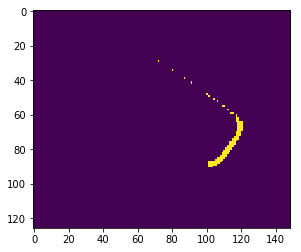

In [190]:
plt.imshow(template)

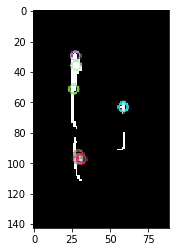

In [188]:
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(template,None)
img=cv2.drawKeypoints(template,kp,template)
plt.imshow(img)

In [186]:
template

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)